In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import Tracking_Py
import random
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [2]:
def load_data(filepath):
    
    # with h5py.File(filepath+"U_matrix", "r") as file:    
    #     U = file["matrix"][:]
    # with h5py.File(filepath+"V_matrix", "r") as file:    
    #     V = file["matrix"][:]
    # with h5py.File(filepath+"xgrid_matrix", "r") as file:    
    #     x_grid = file["matrix"][:]
    # with h5py.File(filepath+"ygrid_matrix", "r") as file:    
    #     y_grid = file["matrix"][:]

    with h5py.File(filepath, "r") as file:
        U = file["U"][:]
        V = file["V"][:]
        M = file["M"][:]
        x_grid = file["x_grid"][:]
        y_grid = file["y_grid"][:]

    return U, V, x_grid, y_grid

In [3]:
file_path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/featherbud_formation_chicken/featherbud_periderm/PIV_periderm_0-100.h5"

U, V, xgrid, ygrid = load_data(file_path)

# Replace nan in U and V into zeros.
U = np.nan_to_num(U) # (#step, 63, 53) dimensional numpy array.
V = np.nan_to_num(V)

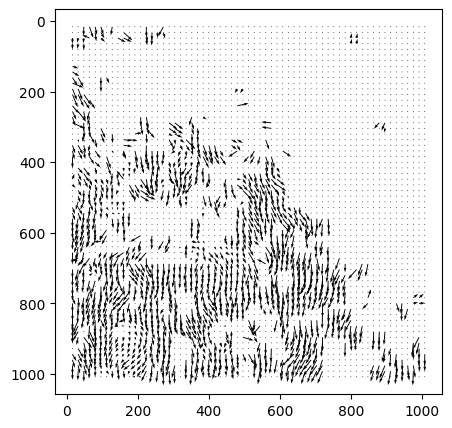

In [4]:
plt.figure(figsize=(5, 5))
plt.gca().invert_yaxis()
plt.quiver(xgrid[100], ygrid[100], V[100], -U[100])

# Pseudo trajectory on the whole image with random start points. 

In [5]:
# Function to check if all values in an array are identical
def has_identical_values(arr):
    return np.all(arr == arr[0])

def whole_image_pseudo_trajectories(U, V, start_number, t0, t1, PIV_step, pxl_conversion, img_name):
    # Generate pseudo_trajectories for the whole image based on PIV results. 
    
    # Random starting points and the time. 
    start_x_array = [[random.randint(20,900)] for i in range(start_number)]
    start_y_array = [[random.randint(20,900)] for i in range(start_number)]

    t_array = [[t0, t1]]*len(start_x_array)
    
    # x and y coordinates of pseudo trajectories. 
    whole_img_x, whole_img_y = Tracking_Py.pseudo_tracking_piv_grid_v2(U, V, t_array,
                                                                  start_x_array,
                                                                  start_y_array, PIV_step)
    
    # Find out the points where there ist no movement -- either in x or y there should be movement (especially for the case of condensate!)
    arrays_to_filter = []
    for i, (x_array, y_array) in enumerate(zip(whole_img_x, whole_img_y)):
        # Check if there no displacement in both x and y directions. 
        if len(np.unique(x_array)) == 1 and len(np.unique(y_array)) == 1:
            arrays_to_filter.append(i)  # Store the index of matching arrays

    # Plotting. 
    plt.figure(figsize=(5,5), dpi=300)
    for i in range(len(start_x_array)): 
        if i not in arrays_to_filter: # Not plotting the points without movements.
            plt.scatter(start_x_array[i], start_y_array[i], color = "orange", s=4)
            plt.plot(whole_img_x[i], whole_img_y[i], color = "royalblue", alpha=0.5)
    plt.gca().invert_yaxis()
    plt.yticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
    #plt.ylabel("distance (μm)")
    plt.xticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
    #plt.xlabel("distance (μm)")
    plt.savefig(img_name + ".svg", format="svg")
    plt.show()

    #return whole_img_x, whole_img_y  # (start_number, time_points_number) dimensional numpy array. 

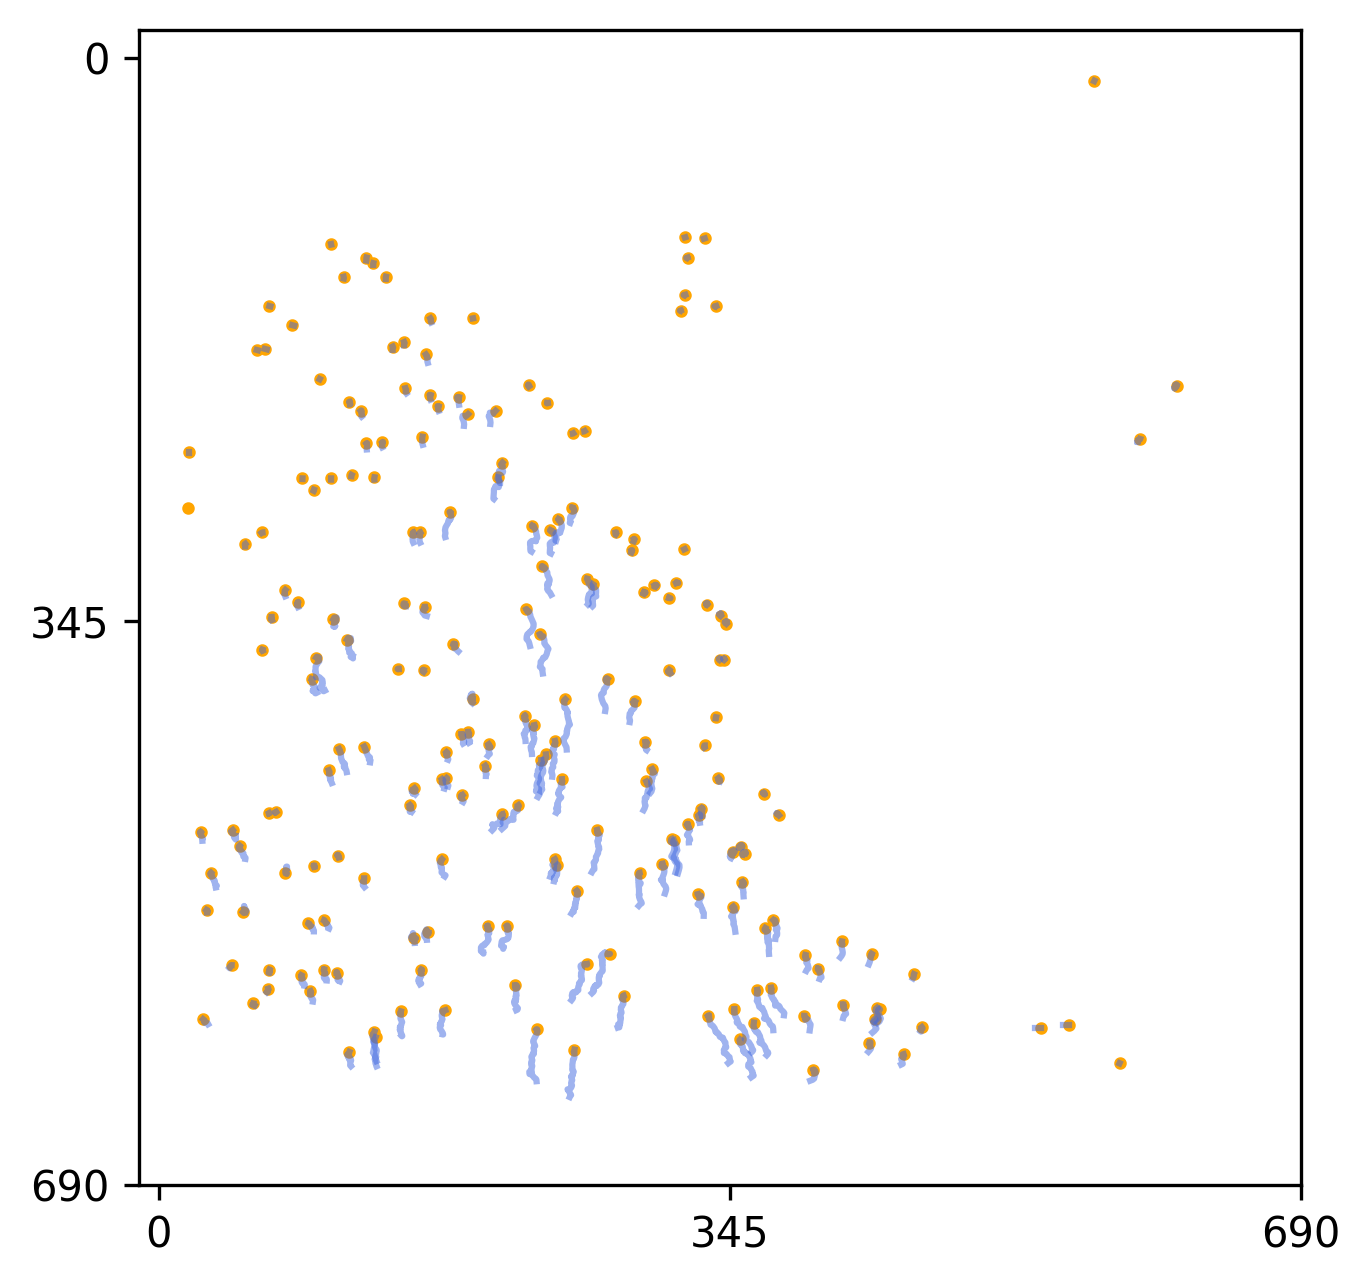

In [6]:
whole_image_pseudo_trajectories(U, V, 500, 0, 50, 16, 0.69, "featherbud_pseudo_tracks_periderm_t0-50")

# Vorticity detection 

In [5]:
# Example: Function to compute vorticity from a 2D velocity field
def compute_vorticity(vx, vy, dx, dy):
    """
    Compute the 2D vorticity field from velocity components.
    
    Parameters:
        vx: 2D numpy array of x-velocity component
        vy: 2D numpy array of y-velocity component
        dx: Spacing between grid points in the x-direction
        dy: Spacing between grid points in the y-direction
    
    Returns:
        vorticity: 2D numpy array of the vorticity field
    """
    # Partial derivatives
    dvdx = np.gradient(vy, dx, axis=1)  # ∂vy/∂x
    dudx = np.gradient(vx, dx, axis=1)  # ∂vx/∂x
    dvdy = np.gradient(vy, dy, axis=0)  # ∂vy/∂y
    dudy = np.gradient(vx, dy, axis=0)  # ∂vx/∂y

    # Vorticity calculation
    vorticity = dvdx - dudy
    return vorticity

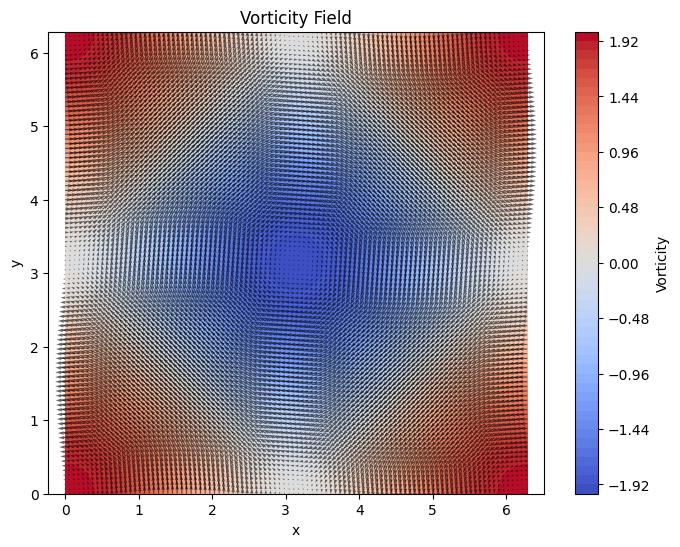

In [26]:
nx, ny = 100, 100  # Grid size
x = np.linspace(0, 2 * np.pi, nx)
y = np.linspace(0, 2 * np.pi, ny)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

# Example velocity field (rotational flow)
vx = -np.sin(Y)
vy = np.sin(X)

# Compute vorticity
vorticity = compute_vorticity(vx, vy, dx, dy)

# Plot the results
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, vorticity, levels=50, cmap="coolwarm")
plt.colorbar(label="Vorticity")
plt.quiver(X, Y, vx, vy, scale=50, color="black", alpha=0.6)
plt.title("Vorticity Field")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

In [30]:
vx

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-6.34239197e-02, -6.34239197e-02, -6.34239197e-02, ...,
        -6.34239197e-02, -6.34239197e-02, -6.34239197e-02],
       [-1.26592454e-01, -1.26592454e-01, -1.26592454e-01, ...,
        -1.26592454e-01, -1.26592454e-01, -1.26592454e-01],
       ...,
       [ 1.26592454e-01,  1.26592454e-01,  1.26592454e-01, ...,
         1.26592454e-01,  1.26592454e-01,  1.26592454e-01],
       [ 6.34239197e-02,  6.34239197e-02,  6.34239197e-02, ...,
         6.34239197e-02,  6.34239197e-02,  6.34239197e-02],
       [ 2.44929360e-16,  2.44929360e-16,  2.44929360e-16, ...,
         2.44929360e-16,  2.44929360e-16,  2.44929360e-16]],
      shape=(100, 100))

In [45]:
vorticity

array([[ 0.        ,  0.        ,  0.        , ...,  0.08435822,
         0.13629675,  0.125     ],
       [ 0.        ,  0.        ,  0.02794385, ...,  0.00370932,
         0.10147119,  0.16113949],
       [ 0.        , -0.03016543,  0.00050735, ..., -0.0554471 ,
         0.07595205,  0.25608397],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.02369642,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.09604239,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(63, 63), dtype=float32)

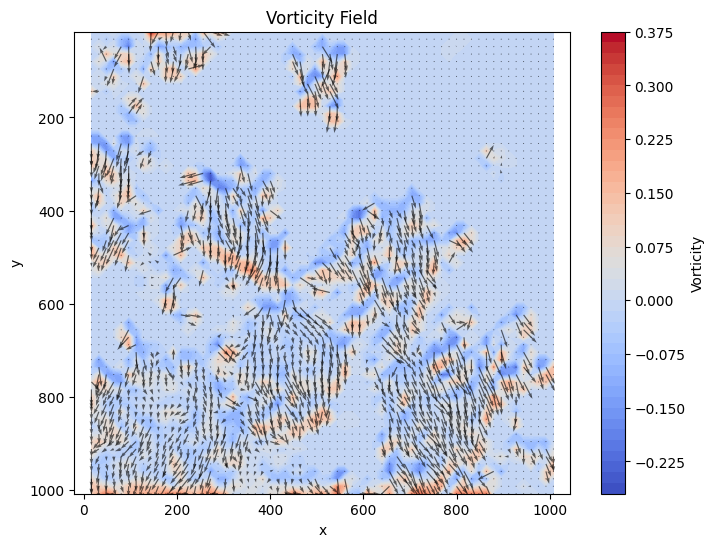

In [39]:
# Compute vorticity
vorticity = compute_vorticity(V[0], -U[0], 16, 16)

# Plot the results
plt.figure(figsize=(8, 6))
plt.contourf(xgrid[0], ygrid[0], vorticity, levels=50, cmap="coolwarm")
plt.colorbar(label="Vorticity")
plt.quiver(xgrid[0], ygrid[0], V[0], -U[0], color="black", alpha=0.6)
plt.gca().invert_yaxis()
plt.title("Vorticity Field")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

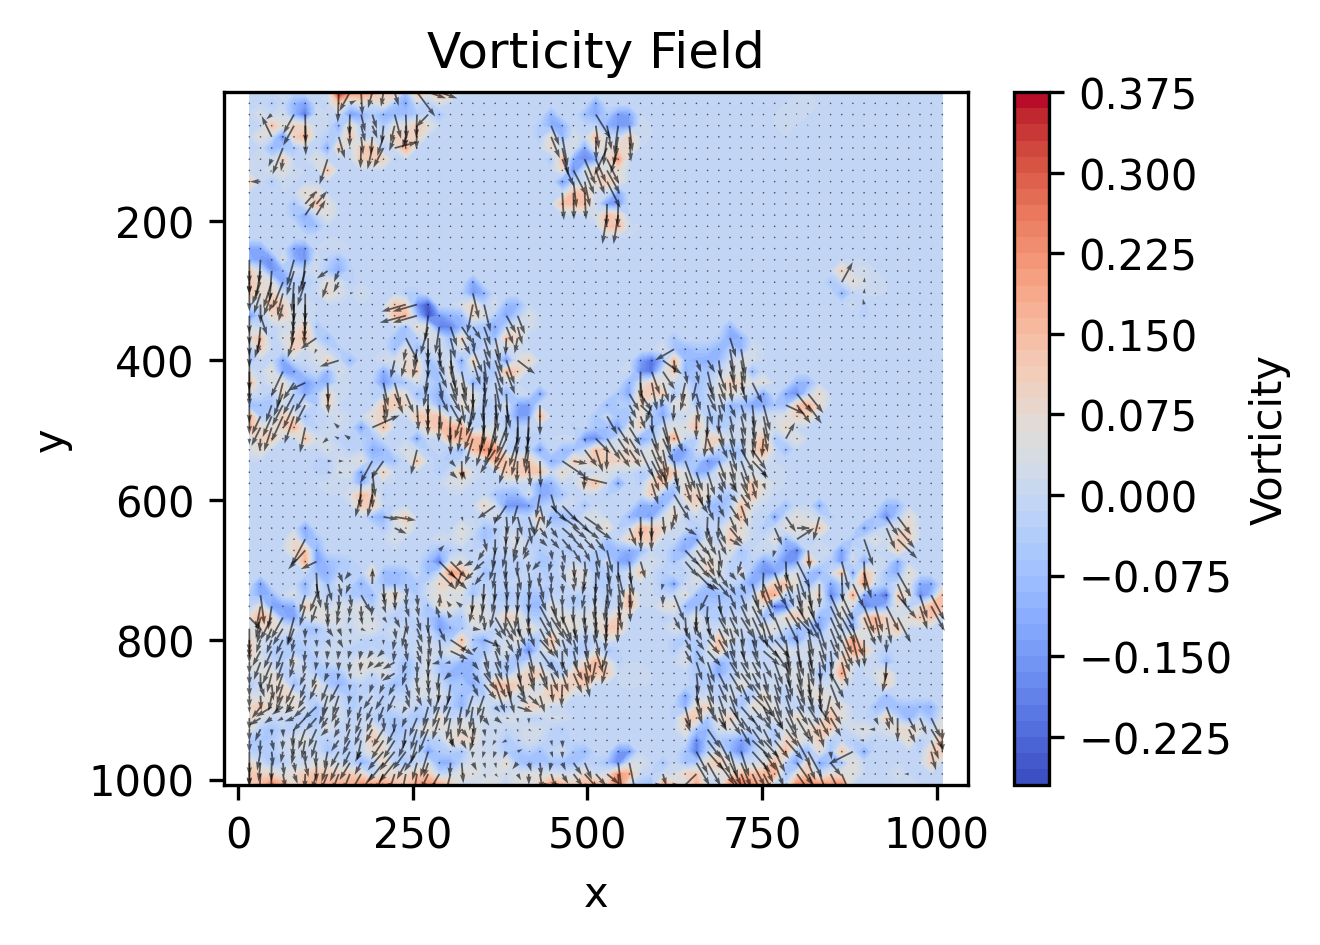

In [7]:
# Make the video of vorticity vector field.

fig = plt.figure(figsize=(4, 3), dpi=300)
x = xgrid[0]
y = ygrid[0]
t_start = 50

def make_frame(i):
    plt.clf()
    
    # Compute vorticity
    vorticity = compute_vorticity(V[i], -U[i], 16, 16)
    
    # Plot the results
    plt.contourf(x, y, vorticity, levels=50, cmap="coolwarm")
    plt.colorbar(label="Vorticity")
    plt.quiver(x, y, V[i], -U[i], color="black", alpha=0.6)
    plt.gca().invert_yaxis()
    plt.title("Vorticity Field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")

myanim = FuncAnimation(fig, make_frame, frames = 30, interval = 500)
writer = FFMpegWriter(fps=20)
myanim.save("test_vorticity_periderm.mp4", writer=writer)

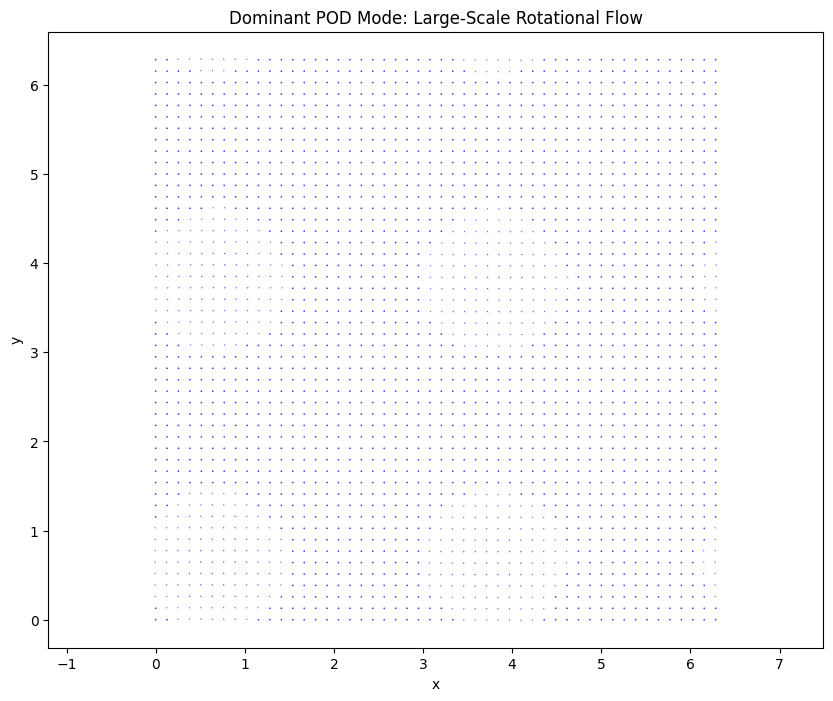

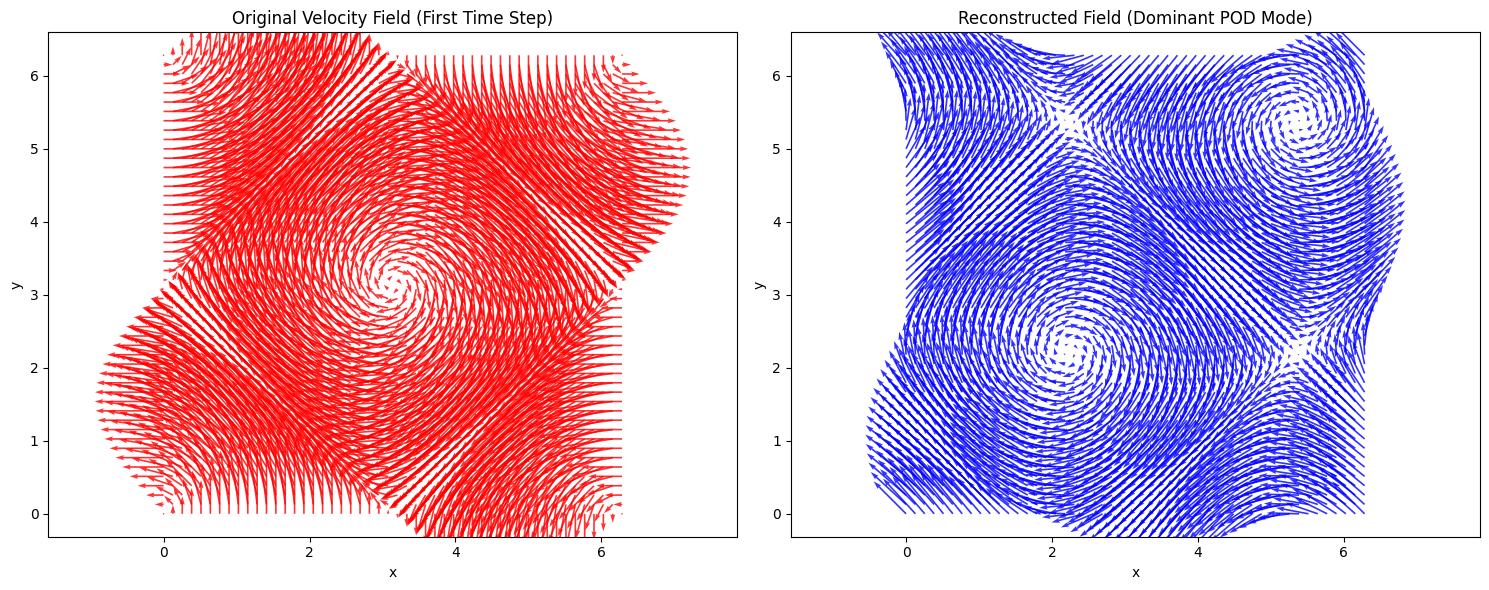

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

# Generate synthetic velocity fields (or load your data)
def generate_velocity_fields(num_timesteps, nx, ny):
    """
    Generate synthetic 2D velocity fields for demonstration purposes.
    """
    x = np.linspace(0, 2 * np.pi, nx)
    y = np.linspace(0, 2 * np.pi, ny)
    X, Y = np.meshgrid(x, y)
    velocity_fields = []
    for t in range(num_timesteps):
        vx = -np.sin(Y + 0.1 * t)  # Example rotational flow in x
        vy = np.sin(X + 0.1 * t)   # Example rotational flow in y
        velocity_fields.append((vx, vy))
    return velocity_fields, X, Y

# Parameters
num_timesteps = 50  # Number of time steps
nx, ny = 50, 50     # Grid size
velocity_fields, X, Y = generate_velocity_fields(num_timesteps, nx, ny)

# Reshape velocity fields into a matrix for POD
def prepare_data_for_pod(velocity_fields):
    """
    Prepare the velocity fields for POD by flattening and stacking.
    """
    data = []
    for vx, vy in velocity_fields:
        # Flatten vx and vy and stack them (concatenated column-wise)
        snapshot = np.hstack((vx.flatten(), vy.flatten()))
        data.append(snapshot)
    return np.array(data)

# Prepare data matrix
data_matrix = prepare_data_for_pod(velocity_fields)  # Shape: (num_timesteps, 2 * nx * ny)

# Perform Singular Value Decomposition (SVD)
U, S, Vt = svd(data_matrix, full_matrices=False)

# Dominant mode reconstruction
dominant_mode = Vt[0, :]  # First (dominant) spatial mode
vx_mode = dominant_mode[:nx * ny].reshape((nx, ny))  # x-component
vy_mode = dominant_mode[nx * ny:].reshape((nx, ny))  # y-component

# Reconstruct large-scale flow for the first time step (optional)
reconstructed_snapshot = S[0] * np.outer(U[:, 0], Vt[0, :])
reconstructed_vx = reconstructed_snapshot[0, :nx * ny].reshape((nx, ny))
reconstructed_vy = reconstructed_snapshot[0, nx * ny:].reshape((nx, ny))

# Visualization of the dominant mode
plt.figure(figsize=(10, 8))
plt.quiver(X, Y, vx_mode, vy_mode, scale=10, color="blue", alpha=0.8)
plt.title("Dominant POD Mode: Large-Scale Rotational Flow")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

# (Optional) Compare original and reconstructed fields
original_vx, original_vy = velocity_fields[0]  # Example: first time step

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.quiver(X, Y, original_vx, original_vy, scale=10, color="red", alpha=0.8)
plt.title("Original Velocity Field (First Time Step)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.quiver(X, Y, reconstructed_vx, reconstructed_vy, scale=10, color="blue", alpha=0.8)
plt.title("Reconstructed Field (Dominant POD Mode)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")

plt.tight_layout()
plt.show()


Video saved as sine_wave.mp4


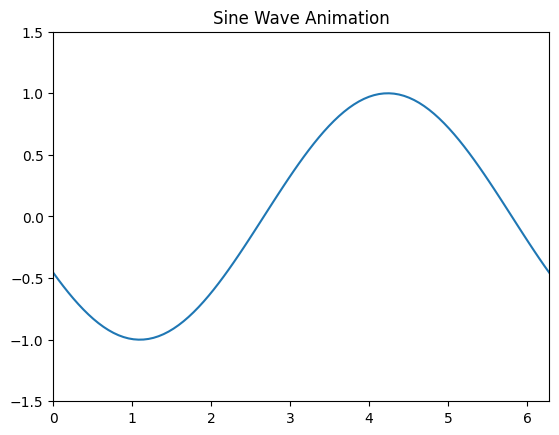

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Define the figure and axis
fig, ax = plt.subplots()
x = np.linspace(0, 2 * np.pi, 100)
line, = ax.plot(x, np.sin(x))

# Set axis limits
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(0, 2 * np.pi)
ax.set_title("Sine Wave Animation")

# Update function for the animation
def update(frame):
    line.set_ydata(np.sin(x + frame / 10))  # Shift the sine wave
    return line,

# Create the animation
anim = FuncAnimation(fig, update, frames=100, interval=50, blit=True)

# Save the animation as an MP4 file
writer = FFMpegWriter(fps=20, metadata={"title": "Sine Wave Animation"})
anim.save("sine_wave.mp4", writer=writer)

print("Video saved as sine_wave.mp4")